<a href="https://colab.research.google.com/github/Hirakhan15/PCOs/blob/main/PCOs(MobileNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import zipfile

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROOT_DIR = '/content/drive/MyDrive/PCOS'
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
   number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))
   print("",dir,"" ,number_of_images[dir])

 infected  17
 noninfected  15


In [38]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input


In [39]:
def preprocessingImage1(path):
  image_data = ImageDataGenerator(
      zoom_range=0.2,
      shear_range=0.2,
      preprocessing_function=preprocess_input,
      horizontal_flip=True
  )
  image = image_data.flow_from_directory(
      directory=path,
      target_size=(224,224),
      batch_size=32,
      class_mode='binary'
  )
  return image


In [7]:
def preprocessionfImage2(path):
  image_data  = ImageDataGenerator(preprocessing_function= preprocess_input )
  image = image_data.flow_from_directory(
      directory=path,
      target_size=(224,224),
      batch_size=32,
      class_mode='binary'
  )
  return image


In [8]:
def datafolder(path,split):
  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+path+"/"+dir)
      for img in np.random.choice(
          a=os.listdir(os.path.join(ROOT_DIR,dir)),
          size=(math.floor(split * number_of_images[dir])-5),
          replace=False):

          O = os.path.join(ROOT_DIR,dir,img)
          D = os.path.join("./"+path,dir)
          shutil.copy(O,D)
          os.remove(O)

  else:
     print("Folder already exist")

In [42]:

datafolder("train",0.7)

Folder already exist


In [43]:
import shutil
import random

# Paths for classes in train folder (adjust names if your folders are 'noninfected' or similar)
minority_class = 'noninfected'  # Minority: 5000 total, so ~3500 in train (70% split)
majority_class = 'infected'     # Majority: 6784 total, so ~4748 in train
train_minority_path = os.path.join('/content/train', minority_class)
train_majority_path = os.path.join('/content/train', majority_class)

# Get initial counts (after split)
num_minority = len(os.listdir(train_minority_path))
num_majority = len(os.listdir(train_majority_path))
print(f"Initial: Minority={num_minority}, Majority={num_majority}")

# Step 1: Undersample majority (e.g., to 1.2x minority size; adjust target for your needs)
target_majority = int(num_minority * 1.2)  # Example: Slight undersample to ~4200 if num_minority~3500
if num_majority > target_majority:
    majority_images = os.listdir(train_majority_path)
    remove_count = num_majority - target_majority
    for i in range(remove_count):
        img = random.choice(majority_images)
        os.remove(os.path.join(train_majority_path, img))
        majority_images.remove(img)  # Avoid re-selecting
    num_majority = len(os.listdir(train_majority_path))  # Update
    print(f"After undersampling: Majority={num_majority}")

# Step 2: Oversample minority to match the new majority count
if num_minority < num_majority:
    oversample_count = num_majority - num_minority
    minority_images = os.listdir(train_minority_path)
    for i in range(oversample_count):
        img = random.choice(minority_images)
        src = os.path.join(train_minority_path, img)
        dst = os.path.join(train_minority_path, f"oversampled_{i}_{img}")
        shutil.copy(src, dst)
    num_minority = len(os.listdir(train_minority_path))  # Update
    print(f"After oversampling: Minority={num_minority}")

# Recreate train_data to include changes (with augmentation for variety)
train_data = preprocessingImage1('/content/train')

# Check final balance
print(np.unique(train_data.classes, return_counts=True))

Initial: Minority=4194, Majority=4194
Found 8388 images belonging to 2 classes.
(array([0, 1], dtype=int32), array([4194, 4194]))


In [44]:
datafolder("val",0.15)

Folder already exist


In [45]:
datafolder("test",0.15)

Folder already exist


In [46]:
path ='/content/train'
train_data = preprocessingImage1(path)

Found 8388 images belonging to 2 classes.


In [47]:
# Compute class weights for imbalance
from sklearn.utils.class_weight import compute_class_weight

# Get class labels from the generator (all labels in train_data)
train_labels = train_data.classes  # Array of 0s and 1s for each sample

# Compute weights (balanced mode automatically handles imbalance)
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(zip(np.unique(train_labels), class_weights))  # e.g., {0: 1.5, 1: 0.8} if class 0 is minority

print("Class weights:", class_weights)

Class weights: {np.int32(0): np.float64(1.0), np.int32(1): np.float64(1.0)}


In [48]:

path ='/content/test'
test_data = preprocessionfImage2(path)

Found 1757 images belonging to 2 classes.


In [49]:


path = '/content/val'
val_data = preprocessionfImage2(path)

Found 1757 images belonging to 2 classes.


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
import keras

In [52]:
base_model = MobileNet(input_shape=(224,224,3),include_top=False)

In [53]:
for layer in base_model.layers:
  layer.trainable = False

In [54]:
x= Flatten()(base_model.output)
x= Dense(units=1,activation='sigmoid')(x)

In [55]:
model = Model(base_model.input,x)

In [56]:
model.compile(optimizer='rmsprop',
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy'])


In [57]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

mc = ModelCheckpoint(filepath="bestmodel.h5",
                     monitor='val_accuracy',
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor="val_accuracy",
                   min_delta=0.01,
                   patience=5,
                   verbose=1)

cb = [mc,es]

In [58]:
# Balance dataset using class_weight
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Extract labels from train_data
labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

NameError: name 'train_data' is not defined

In [1]:
hist = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=cb,
    class_weight=class_weights
)


NameError: name 'model' is not defined

In [25]:
model = load_model("/content/bestmodel.h5")

In [26]:
acc = model.evaluate(test_data)[1]
print(f"Our model accuracy is {acc * 100:.2f}%")


55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9928 - loss: 0.1197
Our model accuracy is 99.15%


In [27]:
h = hist.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
train_data.class_indices

{'infected': 0, 'noninfected': 1}

In [29]:

test_data.class_indices

{'infected': 0, 'noninfected': 1}

In [30]:
val_data.class_indices

{'infected': 0, 'noninfected': 1}

In [31]:

# Predict function
from keras.preprocessing import image
import tensorflow as tf

def predictimage(path):
      img = tf.keras.utils.load_img(path,target_size=(224,224))
      i = tf.keras.utils.img_to_array(img)/255
      input_arr= np.array([i])
      input_arr.shape

      pred =model.predict(input_arr)
      if pred == 1:
          print("Not Affected")
      else :
         print("Affected")
      plt.imshow(input_arr[0],vmin=0, vmax=255)
      plt.title("input Image")
      plt.show()


In [ ]:
# Step 1: Upload image from your laptop
from google.colab import files
uploaded = files.upload()

# Step 2: Get the uploaded file name
import os
for fn in uploaded.keys():
    file_path = os.path.join("/content", fn)
    print("Uploaded file path:", file_path)

    # Step 3: Run prediction on the uploaded image
    predictimage(file_path)


55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step
Confusion Matrix:
[[580 432]
 [419 326]]


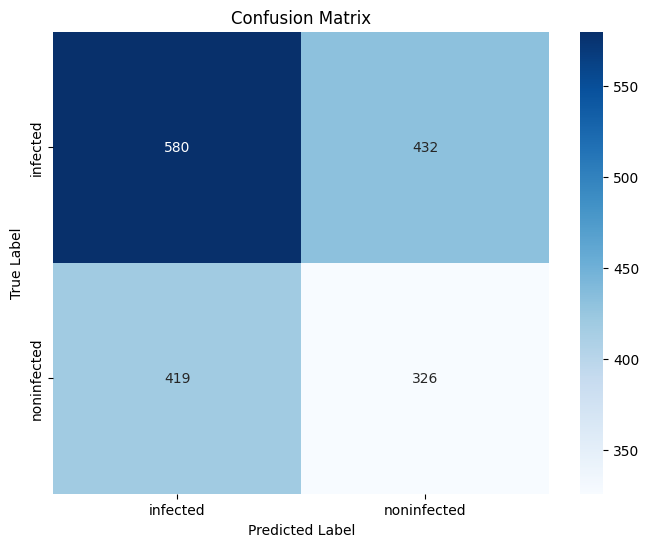


Classification Report:
              precision    recall  f1-score   support

    infected       0.58      0.57      0.58      1012
 noninfected       0.43      0.44      0.43       745

    accuracy                           0.52      1757
   macro avg       0.51      0.51      0.51      1757
weighted avg       0.52      0.52      0.52      1757



In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming model is your trained Keras model and test_data is your Keras DirectoryIterator

# Collect predictions and true labels from the Keras model and test_data
all_preds = model.predict(test_data)
all_labels = test_data.classes

# Get the class indices for proper mapping
class_indices = test_data.class_indices
# Reverse the dictionary to map integer labels back to class names
class_names = dict((v,k) for k,v in class_indices.items())

# Convert predictions to binary (0 or 1)
# Assuming sigmoid activation for binary classification (as used in your model)
predicted_classes = (all_preds > 0.5).astype(int).flatten()

# Ensure the true labels are also flattened if they are not already
true_classes = all_labels # test_data.classes is already a 1D array

# Using scikit-learn for Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_names.values()),
            yticklabels=list(class_names.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(class_names.values())))

# Optionally, save to CSV
np.savetxt('confusion_matrix.csv', cm, delimiter=',', fmt='%d')